# Classification of lung sounds using CNNs

Download dataset from google drive and unzip content

In [1]:
!gdown --id 1g5GFcoy45pJgMwn59WoNy29naPSHp5wf
!unzip lung_sounds.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1g5GFcoy45pJgMwn59WoNy29naPSHp5wf
To: /content/lung_sounds.zip
100% 39.8M/39.8M [00:00<00:00, 53.9MB/s]
Archive:  lung_sounds.zip
   creating: lung_sounds/
   creating: lung_sounds/Audio_Files/
  inflating: lung_sounds/Audio_Files/BP100_N,N,P R M,70,F.wav  
  inflating: lung_sounds/Audio_Files/BP101_Asthma,E W,P L M,12,F.wav  
  inflating: lung_sounds/Audio_Files/BP102_N,N,P L L,41,M.wav  
  inflating: lung_sounds/Audio_Files/BP103_N,N,P R U,81,F.wav  
  inflating: lung_sounds/Audio_Files/BP104_Asthma,E W,P L U,45,F.wav  
  inflating: lung_sounds/Audio_Files/BP105_Lung Fibrosis,Crep,A U R,44,M.wav  
  inflating: lung_sounds/Audio_Files/BP106_Asthma,E W,P L U,45,F.wav  
  inflating: lung_sounds/Audio_Files/BP107_Asthma,E W,

# Objective :

This project seeks to demonstrate the capability of modern deep neural network(DNN) architectures for processing and classifying audio data. The objective of the project is to use DNNs to assist in the diagnosis of respiratory diseases using recordings from healthy and unhealthy patients. Audio samples are transformed into multi-channel matrix data which is then processed using a convolutional neural network(CNN) to one of eight health conditions (Normal, Asthma, Pneumonia, COPD, Bronchitis, Heart Failure, Lung Fibrosis and Pleural Effusion)

In [2]:
import os
import random
import time, copy
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import librosa
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# maximum sample duration is seconds
MAX_SAMPLE_LENGTH = 30
DATA_PATH = "lung_sounds"
WAV_PATH = "Audio_Files"
ANNOTATIONS_FILE = "Data_annotation.csv"
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1

# The Dataset :

The dataset used for this activity consists of lung sounds in .wav format that were acquired using an electronic stethoscope placed on different parts of the patient’s chest wall. The recorded data is processed using three frequency filters that amplify sounds with emphasis on [20-200] Hz, [100-500] Hz and [50-500] Hz ranges. For this activity, samples with emphasis on [50-500] Hz have been considered. The sound samples are of varying duration between 4 and 30 seconds. The dataset contains lung sound samples from 112 subjects (35 healthy and 77 unhealthy) with 43 females and 69 males. The health conditions represented by the dataset are : Normal(35),  Asthma(32), Pneumonia(5), COPD(9), Bronchitis(3), Heart failure(21), Lung fibrosis(5) and Pleural effusion(2).  All samples have a sampling rate of 4000.

The dataset is made available by King Abdullah University Hospital, Ramtha/Irbid, Jordan and can be accessed at (A dataset of lung sounds recorded from the chest wall using an electronic stethoscope - Mendeley Data https://data.mendeley.com/datasets/jwyy9np4gv/3 )

The function below reads in the annotations csv file for the patient diagnosis dataset and creates a labels data frame and labels map. This function also replicates a sample to corresponding classes if the sample has more than one diagnosis. Lastly this function uses oversampling to create a balanced dataset.

In [3]:
def load_labels(filepath):
    labels_df = pd.read_csv(filepath, ",")
    labels_df.insert(
        loc=0, column="Patient_Number", value=np.arange(len(labels_df)) + 1
    )
    row = []
    lg = len(labels_df)
    for i in range(lg):
        label = str(labels_df.loc[i, "Diagnosis"])
        x = label.find("+")
        if x != -1:
            row = labels_df.loc[i].values
            labels_df.loc[i, "Diagnosis"] = label[: x - 1]
            row[-1] = label[x + 2 :]
            labels_df.loc[len(labels_df)] = row
    labels_df = labels_df.sort_values(by="Patient_Number")
    labels_df["Diagnosis"] = labels_df["Diagnosis"].str.lower()
    labels_df["Diagnosis"] = labels_df["Diagnosis"].str.strip()
    maxcnt = labels_df["Diagnosis"].value_counts().max()
    labels = labels_df["Diagnosis"].unique()
    labels_map = {label: class_id for class_id, label in enumerate(labels)}
    for val in labels_map:
        idxs = []
        idxs = labels_df.index[labels_df["Diagnosis"] == val].tolist()
        for i in range(maxcnt - len(idxs)):
            addidx = random.choice(idxs)
            labels_df.loc[len(labels_df)] = labels_df.loc[addidx]
    labels_df = labels_df.sample(frac=1)
    return labels_df, labels_map


This function extracts features from audio samples. Features are extracted from the audio samples using three separate methods.
- Mel Spectrogram : Provides a perceptual representation of the frequency content of the audio signal over time using mel scale, which is tuned for human perception.
- MFCC: Mel frequency cepstral coefficients(MFCCs) are a small set of features that concisely describe the overall shape of the spectral envelope. MFCCs are derived from the power spectrum of the signal using DCT.
- STFT: Short Time Fourier Transform represents how the frequency spectrum of a sample varies over time.

The extracted features are converted into a 3-D image representation with each feature representing one of the features of the same sample. This ‘3D Image’ is ingested by the deep neural network

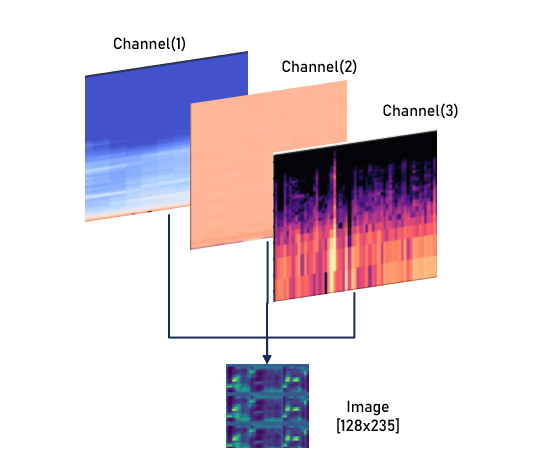

In [4]:
def get_features(
    filepath,
    sampling_rate=None,
    n_fft=4096,
    hop_length=512,
    n_mels=128,
    fmin=20,
    fmax=2100,
    top_db=80,
):
    wav, sampling_rate = librosa.load(filepath, sr=sampling_rate)
    wav, _ = librosa.effects.trim(wav)
    while len(wav) < sampling_rate * MAX_SAMPLE_LENGTH:
        wav = np.pad(
            wav,
            int(np.ceil((MAX_SAMPLE_LENGTH * sampling_rate - wav.shape[0]) / 2)),
            mode="reflect",
        )
    wav = wav[: sampling_rate * MAX_SAMPLE_LENGTH]
    melspec = librosa.feature.melspectrogram(
        y=wav,
        sr=sampling_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        fmin=fmin,
        fmax=fmax,
    )

    mfccs = librosa.feature.mfcc(
        y=wav,
        sr=sampling_rate,
        n_mfcc=n_mels,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        fmin=fmin,
        fmax=fmax,
        dct_type=2,
    )
    stft = np.abs(librosa.stft(wav, n_fft=255, hop_length=hop_length))
    image = melspec
    image = np.dstack((image, mfccs))
    image = np.dstack((image, stft))
    image = np.transpose(image, (2, 0, 1))
    return image

Below function can be used for visualizing the extracted audio features from the samples.

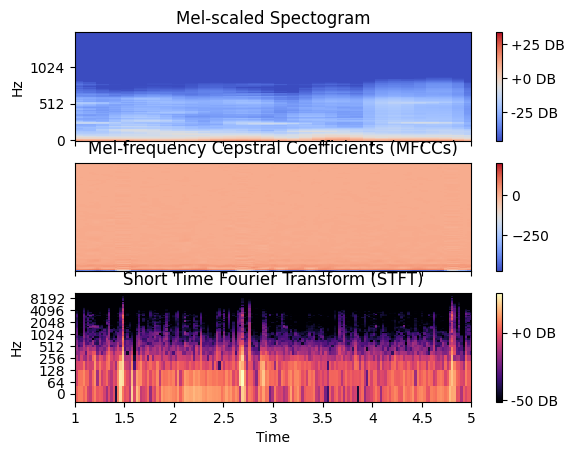

In [5]:
def view_samples(filepath, sampling_rate = None, n_fft = 4096, hop_length = 512,n_mels = 128, fmin = 20, fmax=2000,top_db=80):
    wav, sampling_rate = librosa.load(filepath,sr=sampling_rate)
    wav, _ = librosa.effects.trim(wav)
    while len(wav) < sampling_rate * MAX_SAMPLE_LENGTH:
         wav = np.pad(wav,int(np.ceil((MAX_SAMPLE_LEGNTH * sampling_rate - wav.shape[0])/2)),mode='reflect')
    wav = wav[:sampling_rate*MAX_SAMPLE_LENGTH]
    melspec = librosa.feature.melspectrogram(y=wav,sr=sampling_rate,n_fft=n_fft, hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    melspec_db = librosa.power_to_db(melspec,top_db=top_db)
    mfccs = librosa.feature.mfcc(y=wav,sr=sampling_rate,n_mfcc=n_mels,n_fft=n_fft, hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax,dct_type=2)
    stft = np.abs(librosa.stft(wav,n_fft=255, hop_length=hop_length))
    amplitude_db = librosa.amplitude_to_db(stft)
    fig ,ax = plt.subplots(nrows=3,ncols=1,sharex=True)
    img1 = librosa.display.specshow(melspec_db,x_axis='time',y_axis='mel',sr=sampling_rate,ax=ax[0])
    ax[0].set(title='Mel-scaled Spectogram')
    img2 = librosa.display.specshow(mfccs,x_axis='time',ax=ax[1])
    ax[1].set(title='Mel-frequency Cepstral Coefficients (MFCCs)')
    img3 = librosa.display.specshow(amplitude_db,x_axis='time',y_axis='log',ax=ax[2])
    ax[2].set(title='Short Time Fourier Transform (STFT)')
    for ax_i in ax:
        ax_i.label_outer()
    fig.colorbar(img1, ax=[ax[0]],format='%+2.0f DB')
    fig.colorbar(img2, ax=[ax[1]])
    fig.colorbar(img3,ax=[ax[2]],format='%+2.0f DB')
    ax[0].set(xlim=[1, 5])
    ax[1].set(xlim=[1, 5])
    ax[2].set(xlim=[1, 5])

samplefile = 'EP1_Asthma,I E W,P L L,70,M.wav'
view_samples(os.path.join(DATA_PATH,WAV_PATH,samplefile))

Create a custom Dataset class by extending the PyTorch Dataset class. The dataset class also provides methods for retriving the label map with unique keys and indexes and a method to retrive the shape of the input image.

In [6]:
class MendeleyLungSounds(Dataset):
    def __init__(self, data_path, wav_dir, labels_csv, transform=None):
        self.datapath = data_path
        self.wav_dir = wav_dir
        self.labels_csv = labels_csv
        self.transform = None
        self.labels = []
        self.labels_df, self.labels_map = load_labels(
            os.path.join(data_path, labels_csv)
        )
        self.filelist = os.listdir(os.path.join(data_path, wav_dir))
        image = get_features(os.path.join(self.datapath, self.wav_dir, self.filelist[0]))
        self.image_shape = image.shape

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        item = self.labels_df["Patient_Number"][idx]
        subs = "EP" + str(item) + "_"
        filename = "".join(filter(lambda x: subs in x, self.filelist))
        image = get_features(os.path.join(self.datapath, self.wav_dir, filename))
        class_idx = self.labels_map[self.labels_df["Diagnosis"][idx]]
        if self.transform:
            return self.transform(image), class_idx
        else:
            return torch.from_numpy(image), torch.tensor([class_idx])

    def get_classes(self):
        return self.labels_map

    def get_shape(self):
        return self.image_shape

Utility function to perform training, validation and testing cycles. The function converts labels to one-hot encoded representation for calculating loss.

In [7]:
def train_classification_model(
    device,
    model,
    dataloaders,
    dataset_sizes,
    criterion,
    optimizer,
    scheduler,
    num_epochs=25,
):
    since = time.time()

    best_model_wts = copy.deepcopy(
        model.state_dict()
    )  # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ["train", "val", "test"]

    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase + "_loss"] = []
        training_curves[phase + "_acc"] = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        for phase in phases:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # No need to flatten the inputs!
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    labels = labels.squeeze()
                    # loss = criterion(outputs, labels)
                    one_label = torch.nn.functional.one_hot(
                        labels, num_classes=8
                    ).float()
                    loss = criterion(outputs, one_label)

                    # backward + update weights only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase + "_loss"].append(epoch_loss)
            training_curves[phase + "_acc"].append(epoch_acc)

            print(f"{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model if it's the best accuracy (bas
            if phase == "val" and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:4f} at epoch {best_epoch}")

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves


Load custom dataset and split into train(80%), validation(10%) and test(10%) datasets. The function also creates Dataloaders for train, val and test datasets with a batch size of 8.

In [8]:
def LoadDatasets():
    resp_dataset = MendeleyLungSounds(DATA_PATH, WAV_PATH, ANNOTATIONS_FILE)
    input_shape = resp_dataset.get_shape()
    data_classes = resp_dataset.get_classes()
    print(data_classes.keys())
    #input_shape = (3, 128, 235)
   #data_classes = 8
    train_size = int(TRAIN_SPLIT * len(resp_dataset))
    val_size = int(VAL_SPLIT * len(resp_dataset))
    test_size = len(resp_dataset) - val_size - train_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        resp_dataset, [train_size, val_size, test_size]
    )
    data_loaders = {
        "train": DataLoader(dataset=train_dataset, batch_size=8, shuffle=True),
        "val": DataLoader(dataset=val_dataset, batch_size=8, shuffle=True),
        "test": DataLoader(dataset=test_dataset, batch_size=8, shuffle=True),
    }
    dataset_sizes = {
        "train": len(train_dataset),
        "val": len(val_dataset),
        "test": len(test_dataset),
    }
    return data_loaders, dataset_sizes, input_shape, data_classes


Utility functions for plotting training results and confusion matrix represing diagnosis classes.

In [9]:
# Utility functions for plotting your results!
def plot_training_curves(
    training_curves, phases=["train", "val", "test"], metrics=["loss", "acc"]
):
    epochs = list(range(len(training_curves["train_loss"])))
    for metric in metrics:
        plt.figure()
        plt.title(f"Training curves - {metric}")
        for phase in phases:
            key = phase + "_" + metric
            if key in training_curves:
                if metric == "acc":
                    plt.plot(
                        epochs, [item.detach().cpu() for item in training_curves[key]]
                    )
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel("epoch")
        plt.legend(labels=phases)
        #plt.show(block=True)


def classify_predictions(model, device, dataloader):
    model.eval()  # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs), dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:, 1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return (
        all_preds.detach().cpu(),
        all_labels.detach().cpu(),
        all_scores.detach().cpu(),
    )


def plot_cm(model, device, dataloaders, class_labels, phase="test"):
    class_labels = [1, 2, 3, 4, 5, 6, 7, 8]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    cm = metrics.confusion_matrix(labels, preds)
    cr = metrics.classification_report(labels,preds)
    disp = metrics.ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=class_labels
    )
    ax = disp.plot().ax_
    ax.set_title("Confusion Matrix -- counts")
    #plt.show(block=True)
    return cr


In [10]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load custom respiratory dataset
dataloaders, dataset_sizes, input_shape, data_classes = LoadDatasets()

<ipython-input-3-3ce54129db58>:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  labels_df = pd.read_csv(filepath, ",")


dict_keys(['asthma', 'heart failure', 'lung fibrosis', 'copd', 'plueral effusion', 'pneumonia', 'bron', 'n'])


/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


# Baseline Model :

A baseline model is created to classify the converted audio samples and to evaluate the performance against pre-trained models from the model-zoo. The baseline model has the below architecture.

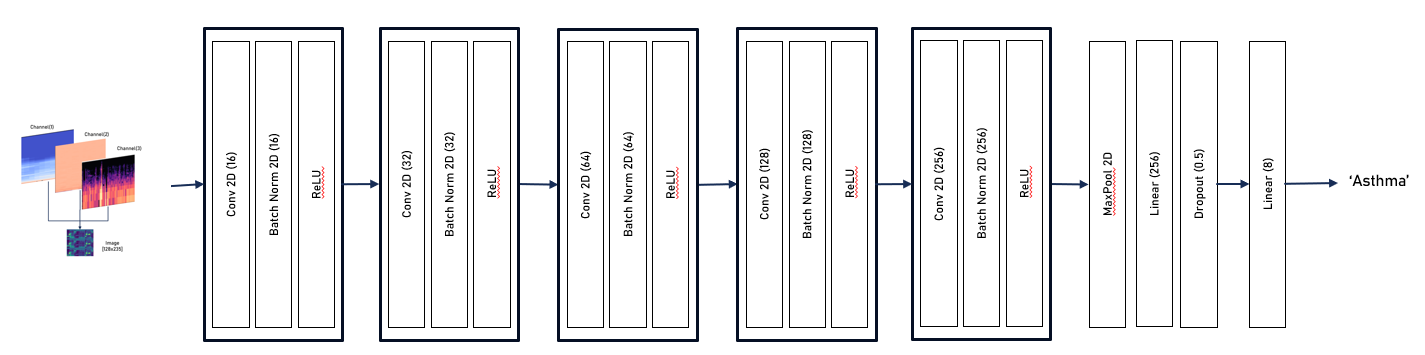





In [11]:
class RespiratoryClassifierModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(RespiratoryClassifierModel, self).__init__()
        self.pipeline = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape[0],
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256 * ((input_shape[1] // 2)) * ((input_shape[2] // 2)), 128), # Changed to 128 from 256 due to out of memory on Google Colab
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes),  # Changed to 128 from 256 due to out of memory on Google Colab
        )

    def forward(self, x):
        return self.pipeline(x)


Training the baseline model

In [12]:
model = RespiratoryClassifierModel(
    input_shape=input_shape, num_classes=len(data_classes)
).to(device)

# parameters
learning_rate = 0.05
num_epochs = 50

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [13]:
model, training_curves = train_classification_model(
    device,
    model,
    dataloaders,
    dataset_sizes,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs,
)


Epoch 1/50
----------


/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


train Loss: 1603.4596 Acc: 0.2143
val   Loss: 7806.9802 Acc: 0.1071
test  Loss: 8527.2528 Acc: 0.1071

Epoch 2/50
----------
train Loss: 15.6220 Acc: 0.4509
val   Loss: 1.7040 Acc: 0.6786
test  Loss: 2.2677 Acc: 0.4643

Epoch 3/50
----------
train Loss: 1.5610 Acc: 0.4643
val   Loss: 0.9843 Acc: 0.6786
test  Loss: 1.6444 Acc: 0.4286

Epoch 4/50
----------
train Loss: 1.3555 Acc: 0.5223
val   Loss: 0.9926 Acc: 0.7143
test  Loss: 1.5909 Acc: 0.5000

Epoch 5/50
----------
train Loss: 1.3298 Acc: 0.6027
val   Loss: 1.0127 Acc: 0.7143
test  Loss: 2.1179 Acc: 0.4643

Epoch 6/50
----------
train Loss: 1.2040 Acc: 0.5893
val   Loss: 0.8662 Acc: 0.7143
test  Loss: 2.1348 Acc: 0.4643

Epoch 7/50
----------
train Loss: 1.1256 Acc: 0.6071
val   Loss: 0.9793 Acc: 0.6429
test  Loss: 2.2551 Acc: 0.5357

Epoch 8/50
----------
train Loss: 1.0878 Acc: 0.6250
val   Loss: 0.9323 Acc: 0.7143
test  Loss: 1.8162 Acc: 0.5357

Epoch 9/50
----------
train Loss: 0.9081 Acc: 0.6964
val   Loss: 1.0472 Acc: 0.7143


Plot traning metrics

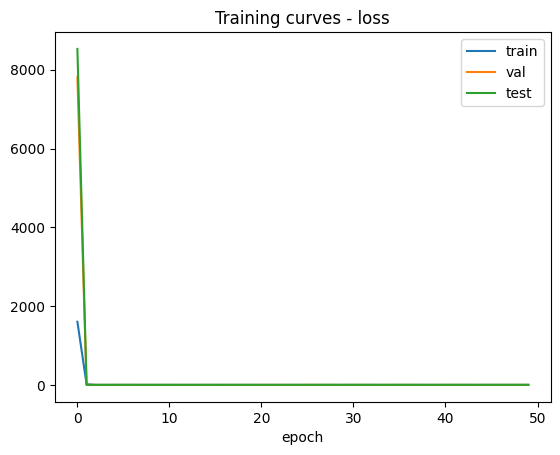

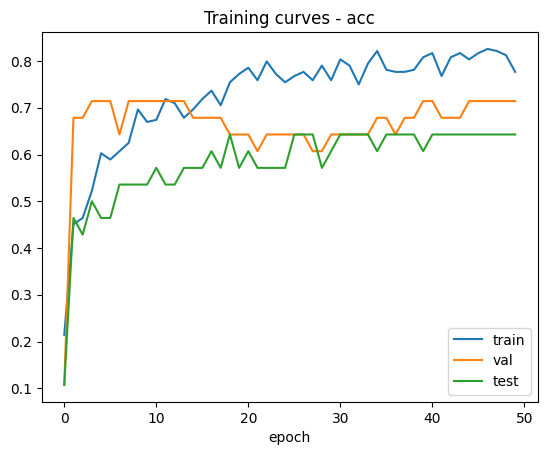

In [14]:
# plot training curves
plot_training_curves(training_curves, phases=["train", "val", "test"])


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


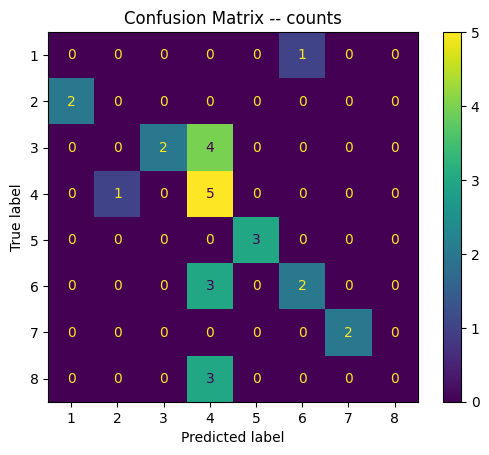

In [15]:
# plot confusion matrix
rep = plot_cm(model, device, dataloaders, data_classes.keys(), phase="test")

In [16]:
# print classification report
print('============== Classification Report ==============')
print(rep)
print('==================================================')


============== Classification Report ==============
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.00      0.00      0.00         2
         2.0       1.00      0.33      0.50         6
         3.0       0.33      0.83      0.48         6
         4.0       1.00      1.00      1.00         3
         5.0       0.67      0.40      0.50         5
         6.0       1.00      1.00      1.00         2
         7.0       0.00      0.00      0.00         3

    accuracy                           0.50        28
   macro avg       0.50      0.45      0.43        28
weighted avg       0.58      0.50      0.48        28



# DenseNet Model :
In addition to using the baseline model. I have also evaluated pre-trainined models for this task

The solution uses a deep neural network architecture named densenet-121 (as described by the paper – Densely Connected Convolutional Networks) introduced by Huang et al in 2016, for this task. A pre-trained version of the model can be downloaded from the Torchvision model zoo (see densenet121 — Torchvision main documentation (pytorch.org)). DenseNet architecture has the advantage of using fewer parameters and allow feature reuse.

The model is modified by removing the last layer and replacing it with a new fully-connected representing the 8 diagnosis classes.

In [17]:
import torchvision.models as model_zoo


class RespiratoryClassifierDenseNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(RespiratoryClassifierDenseNet, self).__init__()
        self.model = model_zoo.densenet121(pretrained=True, progress=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        return self.model(x)

    def train_all(self):
        # Un-Freeze the weights of the network
        for param in self.model.parameters():
            param.requires_grad = True


Set training parameters , load dataset and create an instance of the classifier model.

In [18]:
# parameters
learning_rate = 0.01
num_epochs = 50
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load custom respiratory dataset
dataloaders, dataset_sizes, input_shape, data_classes = LoadDatasets()

# Create instance of the classifier model
model = RespiratoryClassifierDenseNet(
    input_shape=input_shape, num_classes=len(data_classes)
).to(device)


<ipython-input-3-3ce54129db58>:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  labels_df = pd.read_csv(filepath, ",")
/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNe

dict_keys(['asthma', 'heart failure', 'lung fibrosis', 'copd', 'plueral effusion', 'pneumonia', 'bron', 'n'])


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 82.9MB/s]


Specify loss, optimizer and learning rate scheduler.

In [19]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

Transfer learning  - Training Phase 1 : Keep weights frozen for all but the last layer.

In [20]:
model, training_curves = train_classification_model(
    device,
    model,
    dataloaders,
    dataset_sizes,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs,
)



Epoch 1/50
----------
train Loss: 3.2072 Acc: 0.2723
val   Loss: 1.9626 Acc: 0.2857
test  Loss: 2.1049 Acc: 0.3571

Epoch 2/50
----------
train Loss: 1.2735 Acc: 0.5402
val   Loss: 0.9426 Acc: 0.6429
test  Loss: 0.9384 Acc: 0.6429

Epoch 3/50
----------
train Loss: 0.7207 Acc: 0.7455
val   Loss: 0.9744 Acc: 0.6429
test  Loss: 0.6297 Acc: 0.6786

Epoch 4/50
----------
train Loss: 0.9484 Acc: 0.6920
val   Loss: 1.1676 Acc: 0.6071
test  Loss: 0.8465 Acc: 0.7143

Epoch 5/50
----------
train Loss: 0.6549 Acc: 0.7500
val   Loss: 0.8853 Acc: 0.6786
test  Loss: 0.7169 Acc: 0.7143

Epoch 6/50
----------
train Loss: 0.5359 Acc: 0.8304
val   Loss: 0.6738 Acc: 0.7500
test  Loss: 0.6937 Acc: 0.7143

Epoch 7/50
----------
train Loss: 0.4168 Acc: 0.8482
val   Loss: 0.6150 Acc: 0.7857
test  Loss: 0.6459 Acc: 0.7500

Epoch 8/50
----------
train Loss: 0.4666 Acc: 0.8393
val   Loss: 0.9658 Acc: 0.7143
test  Loss: 0.8975 Acc: 0.7500

Epoch 9/50
----------
train Loss: 0.3524 Acc: 0.8750
val   Loss: 0.7747

Training results for Phase-1.

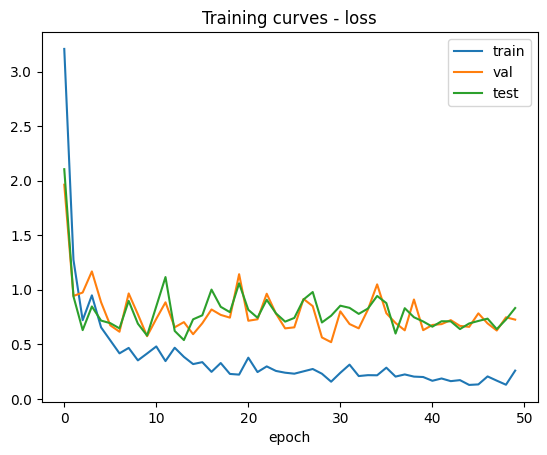

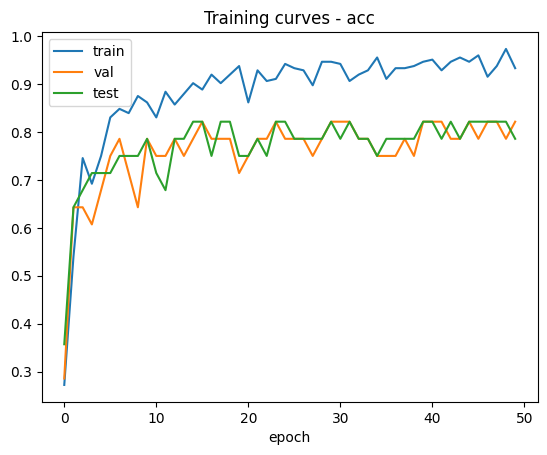

In [21]:
 # plot training curves
plot_training_curves(training_curves, phases=["train", "val", "test"])


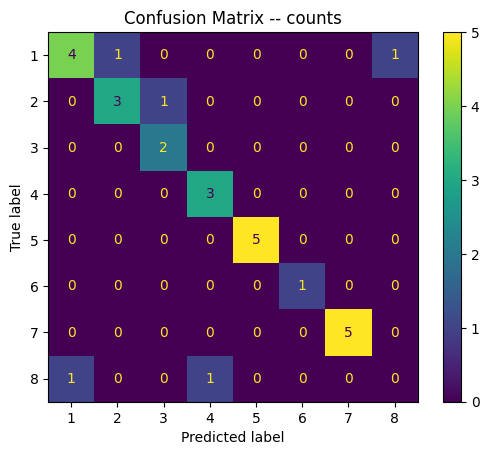

In [22]:
# plot confusion matrix
class_labels = data_classes.keys()
rep = plot_cm(model, device, dataloaders, class_labels, phase="test")

Transfer learning - Traning Phase 2 : Unfreeze all weights

In [23]:
model.train_all()
# # Make sure you save the training curves along the way for visualization afterwards!
model, training_curves = train_classification_model(
    device,
    model,
    dataloaders,
    dataset_sizes,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs,
)


Epoch 1/50
----------


/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


train Loss: 1.8776 Acc: 0.4598
val   Loss: 11.3284 Acc: 0.1071
test  Loss: 10.5938 Acc: 0.0714

Epoch 2/50
----------
train Loss: 1.0319 Acc: 0.6473
val   Loss: 0.8406 Acc: 0.6429
test  Loss: 0.5851 Acc: 0.8214

Epoch 3/50
----------
train Loss: 0.6553 Acc: 0.7768
val   Loss: 0.5363 Acc: 0.7143
test  Loss: 0.5612 Acc: 0.8571

Epoch 4/50
----------
train Loss: 0.6472 Acc: 0.7812
val   Loss: 1.2866 Acc: 0.6786
test  Loss: 0.8743 Acc: 0.7143

Epoch 5/50
----------
train Loss: 0.5059 Acc: 0.8661
val   Loss: 1.0503 Acc: 0.7143
test  Loss: 0.8277 Acc: 0.8214

Epoch 6/50
----------
train Loss: 0.2819 Acc: 0.9330
val   Loss: 0.7508 Acc: 0.8214
test  Loss: 0.6560 Acc: 0.8571

Epoch 7/50
----------
train Loss: 0.3113 Acc: 0.9330
val   Loss: 0.6032 Acc: 0.7857
test  Loss: 0.7915 Acc: 0.7143

Epoch 8/50
----------
train Loss: 0.2568 Acc: 0.9330
val   Loss: 0.8794 Acc: 0.8214
test  Loss: 0.7786 Acc: 0.8214

Epoch 9/50
----------
train Loss: 0.1725 Acc: 0.9554
val   Loss: 0.9486 Acc: 0.7857
test  Lo

Training Results - Phase - 2

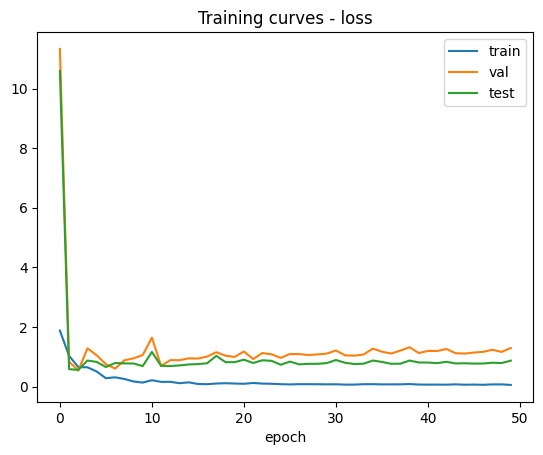

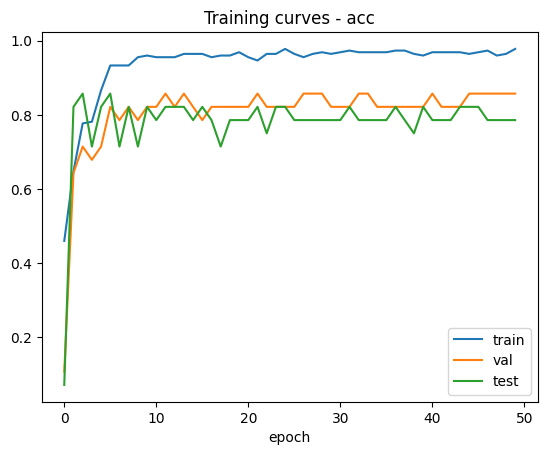

In [24]:
 # plot training curves
plot_training_curves(training_curves, phases=["train", "val", "test"])

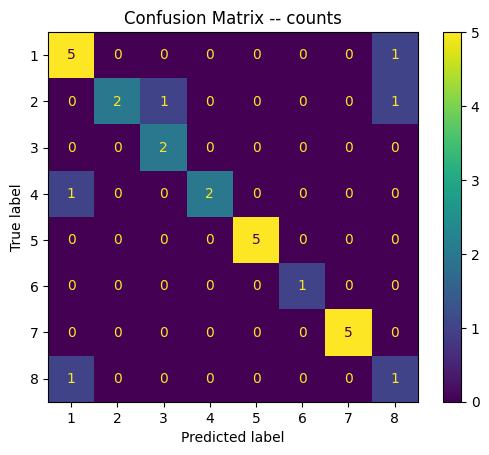

In [25]:
# plot confusion matrix
rep = plot_cm(model, device, dataloaders, data_classes.keys(), phase="test")


In [26]:
# print classification report
print('============== Classification Report ==============')
print(rep)
print('==================================================')



============== Classification Report ==============
              precision    recall  f1-score   support

         0.0       0.71      0.83      0.77         6
         1.0       1.00      0.50      0.67         4
         2.0       0.67      1.00      0.80         2
         3.0       1.00      0.67      0.80         3
         4.0       1.00      1.00      1.00         5
         5.0       1.00      1.00      1.00         1
         6.0       1.00      1.00      1.00         5
         7.0       0.33      0.50      0.40         2

    accuracy                           0.82        28
   macro avg       0.84      0.81      0.80        28
weighted avg       0.87      0.82      0.82        28

